# Robyn: Marketing Mix Modeling Application

This notebook demonstrates the usage of Robyn, a Marketing Mix Modeling (MMM) application. 
We'll go through the main steps of performing robyn_inputs and robyn_engineering.



## 1. Import Required Libraries. Define Paths.

First, let's import the necessary libraries. Make sure to define your paths in the .env file.

In [1]:
from dotenv import load_dotenv
import os
import sys

# Load environment variables from .env file
load_dotenv(dotenv_path=".env.sample")
# Retrieve the ROBYN_BASE_PATH environment variable
base_path = os.getenv("ROBYN_BASE_PATH")
if not base_path:
    raise EnvironmentError("Please set the ROBYN_BASE_PATH environment variable")
# Retrieve the PYTHONPATH environment variable
python_path = os.getenv("PYTHONPATH")
if not python_path:
    raise EnvironmentError("Please set the PYTHONPATH environment variable in the .env file")
# Append the paths to sys.path to recognize them as valid Python package paths
sys.path.append(base_path)
sys.path.append(python_path)

In [2]:
import sys
import os
import numpy as np
import pandas as pd
import pyreadr
from typing import Dict, Any
from robyn.data.entities.mmmdata import MMMData
from robyn.data.entities.holidays_data import HolidaysData
from robyn.data.entities.hyperparameters import Hyperparameters
from robyn.modeling.entities.modelrun_trials_config import TrialsConfig
from robyn.modeling.model_executor import ModelExecutor
from robyn.modeling.ridge_model_builder import RidgeModelBuilder
from robyn.modeling.entities.enums import NevergradAlgorithm, Models
from robyn.modeling.feature_engineering import FeaturizedMMMData, FeatureEngineering

## 2.1 Load Mock R data

We need to set the base path for the data directory.
Create a .env file in the same directory as your notebook and put in define the path to the data dir.
for example: ROBYN_BASE_PATH=.../Robyn/R/data

In [3]:
def load_data() -> Dict[str, pd.DataFrame]:
    base_path = os.getenv("ROBYN_BASE_PATH")
    if not base_path:
        raise EnvironmentError("Please set the ROBYN_BASE_PATH environment variable")

    simulated_weekly_path = os.path.join(base_path, "dt_simulated_weekly.RData")
    prophet_holidays_path = os.path.join(base_path, "dt_prophet_holidays.RData")

    result = pyreadr.read_r(simulated_weekly_path)
    dt_simulated_weekly = result["dt_simulated_weekly"]
    result_holidays = pyreadr.read_r(prophet_holidays_path)
    dt_prophet_holidays = result_holidays["dt_prophet_holidays"]

    return {"dt_simulated_weekly": dt_simulated_weekly, "dt_prophet_holidays": dt_prophet_holidays}


data = load_data()
data["dt_simulated_weekly"].head()
data["dt_prophet_holidays"].head()

,ds,holiday,country,year
0,1995-01-01,New Year's Day,AD,1995
1,1995-01-06,Epiphany,AD,1995
2,1995-02-28,Carnival,AD,1995
3,1995-03-14,Constitution Day,AD,1995
4,1995-04-14,Good Friday,AD,1995


## Setup MMM Data

We will now set up the MMM data specification which includes defining the dependent variable, independent variables, and the time window for analysis.

In [4]:
def setup_mmm_data(data: Dict[str, pd.DataFrame]) -> MMMData:
    dt_simulated_weekly = data["dt_simulated_weekly"]

    mmm_data_spec = MMMData.MMMDataSpec(
        dep_var="revenue",
        dep_var_type="revenue",
        date_var="DATE",
        context_vars=["competitor_sales_B", "events"],
        paid_media_spends=["tv_S", "ooh_S", "print_S", "facebook_S", "search_S"],
        paid_media_vars=["tv_S", "ooh_S", "print_S", "facebook_I", "search_clicks_P"],
        organic_vars=["newsletter"],
        window_start="2016-01-01",
        window_end="2018-12-31",
    )

    return MMMData(data=dt_simulated_weekly, mmmdata_spec=mmm_data_spec)


mmm_data = setup_mmm_data(data)
mmm_data.data.head()

,DATE,revenue,tv_S,ooh_S,print_S,facebook_I,search_clicks_P,search_S,competitor_sales_B,facebook_S,events,newsletter
0,2015-11-23,2.754372e+06,22358.346667,0.0,12728.488889,2.430128e+07,0.000000,0.000000,8125009,7607.132915,na,19401.653846
1,2015-11-30,2.584277e+06,28613.453333,0.0,0.000000,5.527033e+06,9837.238486,4133.333333,7901549,1141.952450,na,14791.000000
2,2015-12-07,2.547387e+06,0.000000,132278.4,453.866667,1.665159e+07,12044.119653,3786.666667,8300197,4256.375378,na,14544.000000
3,2015-12-14,2.875220e+06,83450.306667,0.0,17680.000000,1.054977e+07,12268.070319,4253.333333,8122883,2800.490677,na,2800.000000
4,2015-12-21,2.215953e+06,0.000000,277336.0,0.000000,2.934090e+06,9467.248023,3613.333333,7105985,689.582605,na,15478.000000


## Feature Preprocessing

We will perform feature engineering to prepare the data for modeling. This includes transformations like adstock and other preprocessing steps.

In [5]:
def setup_hyperparameters() -> Hyperparameters:
    return Hyperparameters(
        hyperparameters={
            "facebook_S_alphas": [0.5, 3],
            "facebook_S_gammas": [0.3, 1],
            "facebook_S_thetas": [0, 0.3],
            "print_S_alphas": [0.5, 3],
            "print_S_gammas": [0.3, 1],
            "print_S_thetas": [0.1, 0.4],
            "tv_S_alphas": [0.5, 3],
            "tv_S_gammas": [0.3, 1],
            "tv_S_thetas": [0.3, 0.8],
            "search_S_alphas": [0.5, 3],
            "search_S_gammas": [0.3, 1],
            "search_S_thetas": [0, 0.3],
            "ooh_S_alphas": [0.5, 3],
            "ooh_S_gammas": [0.3, 1],
            "ooh_S_thetas": [0.1, 0.4],
            "newsletter_alphas": [0.5, 3],
            "newsletter_gammas": [0.3, 1],
            "newsletter_thetas": [0.1, 0.4],
        },
        adstock="geometric",
        lambda_=0.0,
        train_size=[0.5, 0.8],
    )


# Setup Hyperparameters
hyperparameters = setup_hyperparameters()
print("Hyperparameters setup complete.")

Hyperparameters setup complete.


In [6]:
# Create HolidaysData object
holidays_data = HolidaysData(
    dt_holidays=data["dt_prophet_holidays"],
    prophet_vars=["trend", "season", "holiday"],
    prophet_country="DE",
    prophet_signs=["default", "default", "default"],
)
# Setup FeaturizedMMMData
feature_engineering = FeatureEngineering(mmm_data, hyperparameters, holidays_data)

In [7]:
featurized_mmm_data = feature_engineering.perform_feature_engineering()

/Users/yijuilee/Library/Python/3.9/lib/python/site-packages/prophet/forecaster.py:187: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
13:22:55 - cmdstanpy - INFO - Chain [1] start processing
2024-10-13 13:22:55 - cmdstanpy - INFO - Chain [1] start processing
13:22:55 - cmdstanpy - INFO - Chain [1] done processing
2024-10-13 13:22:55 - cmdstanpy - INFO - Chain [1] done processing


Prophet decomposition complete.
Processing tv_S
Processing ooh_S
Processing print_S
Processing facebook_S
Processing search_S
Feature engineering complete.


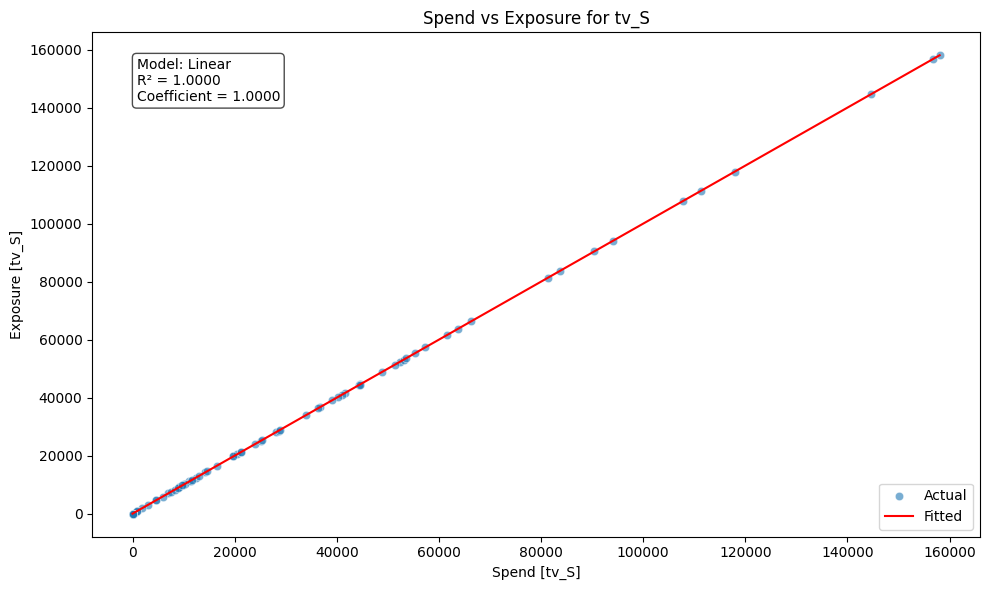

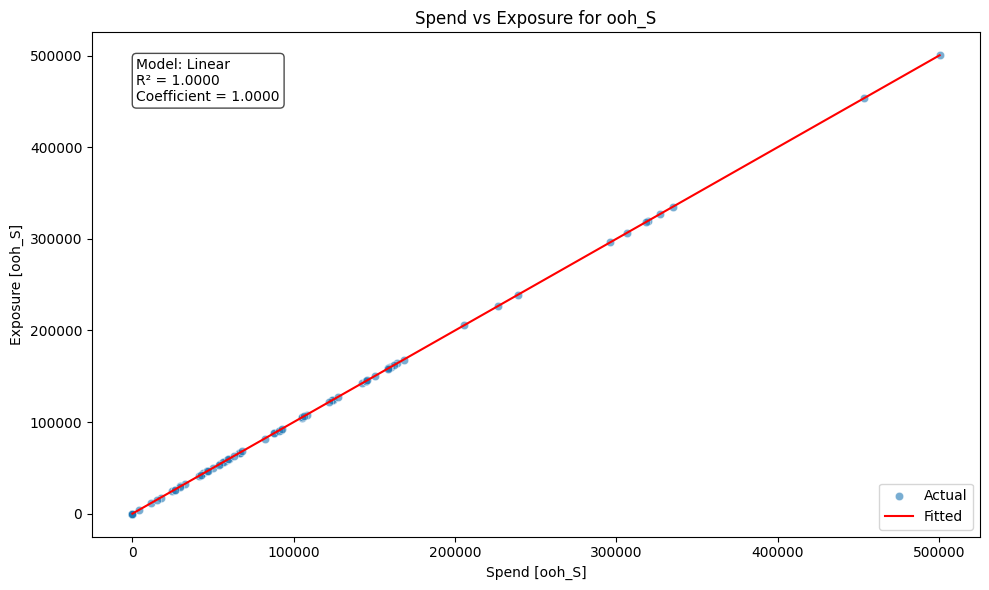

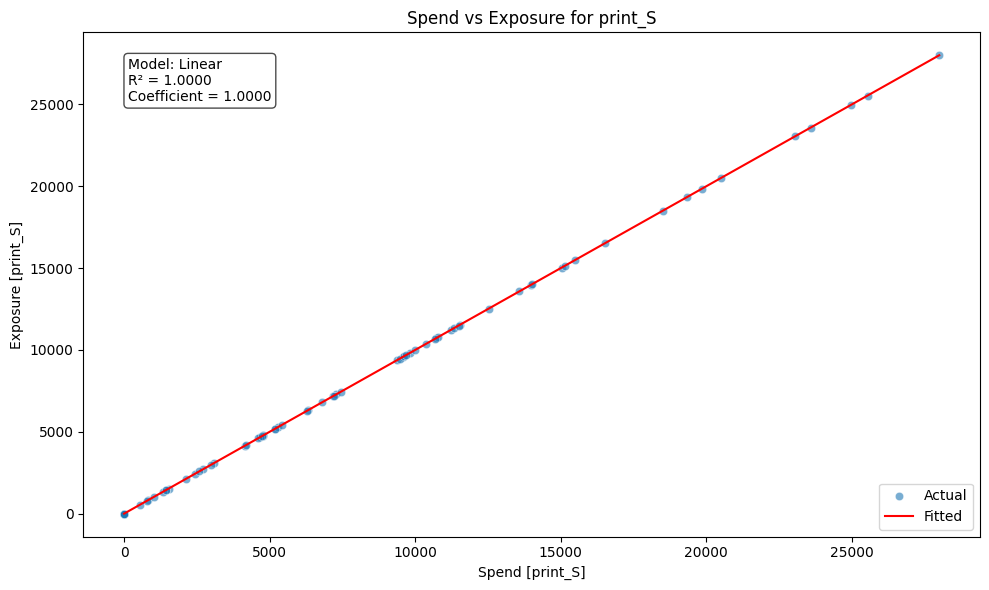

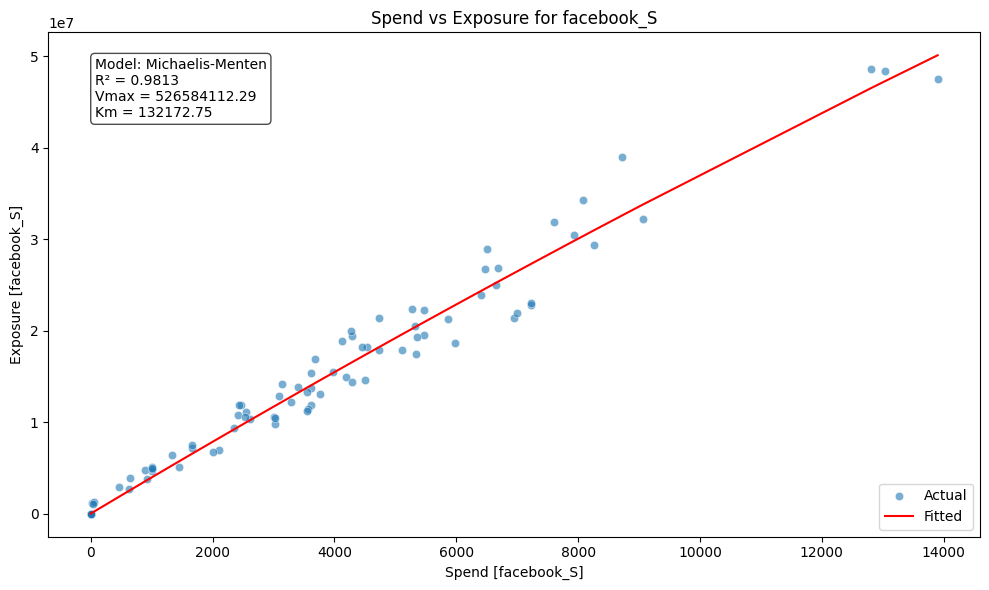

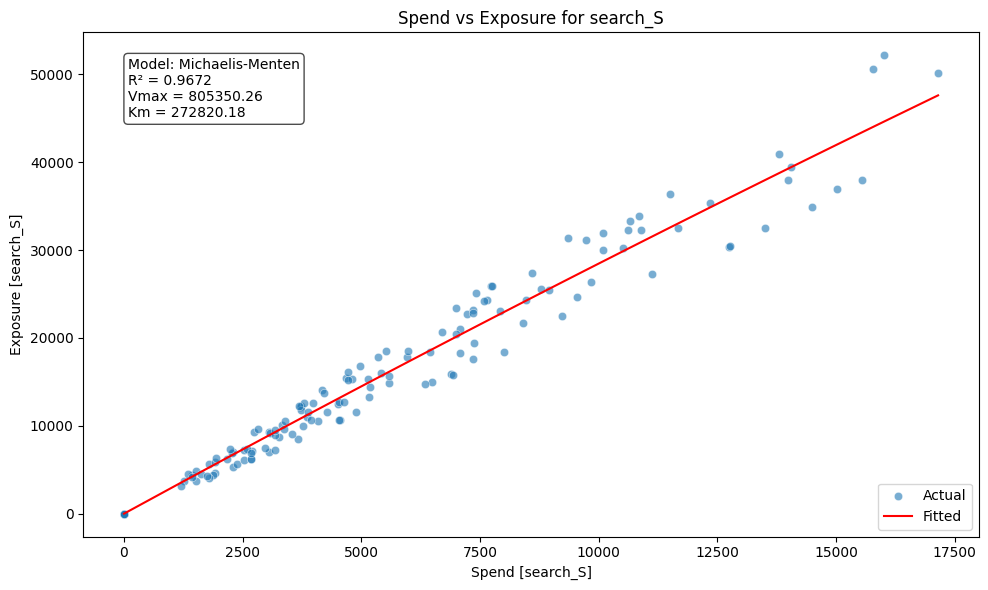

In [8]:
from robyn.visualization.feature_visualization import FeaturePlotter
import matplotlib.pyplot as plt

# Create a FeaturePlotter instance
feature_plotter = FeaturePlotter(mmm_data, hyperparameters)

# Plot spend-exposure relationship for each channel
for channel in mmm_data.mmmdata_spec.paid_media_spends:
    try:
        fig = feature_plotter.plot_spend_exposure(featurized_mmm_data, channel)
        plt.show()
    except ValueError as e:
        print(f"Skipping {channel}: {str(e)}")

>>> Starting 5 trials with 2000 iterations each using TwoPointsDE nevergrad algorithm on x cores...
Input data has 208 weeks in total: 2015-11-23 to 2019-11-11
Initial model is built on rolling window of 157 weeks: 2016-01-01 to 2018-12-31
Time-series validation with train_size range of 50%-80% of the data...
Using geometric adstocking with 18 hyperparameters (18 to iterate + 0 fixed) on 8 cores
>>> Starting 5 trials with 2000 iterations each using TwoPointsDE nevergrad algorithm...


Running trial 1 of total 5 trials: 100%|███████████████████████████████████


 Finished in 1.91 mins


2024-10-13 13:24:55 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-10-13 13:24:55 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-10-13 13:24:55 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Total run time: 1.92 mins
Finished in 1.92 mins
- DECOMP.RSSD converged: sd@qt.20 505.532 <= 45766.081 & |med@qt.20| 111811.26 <= 263673.08
- NRMSE NOT converged: sd@qt.20 0.000 <= 0.001 & |med@qt.20| 0.10 > 0.10
Model training complete.


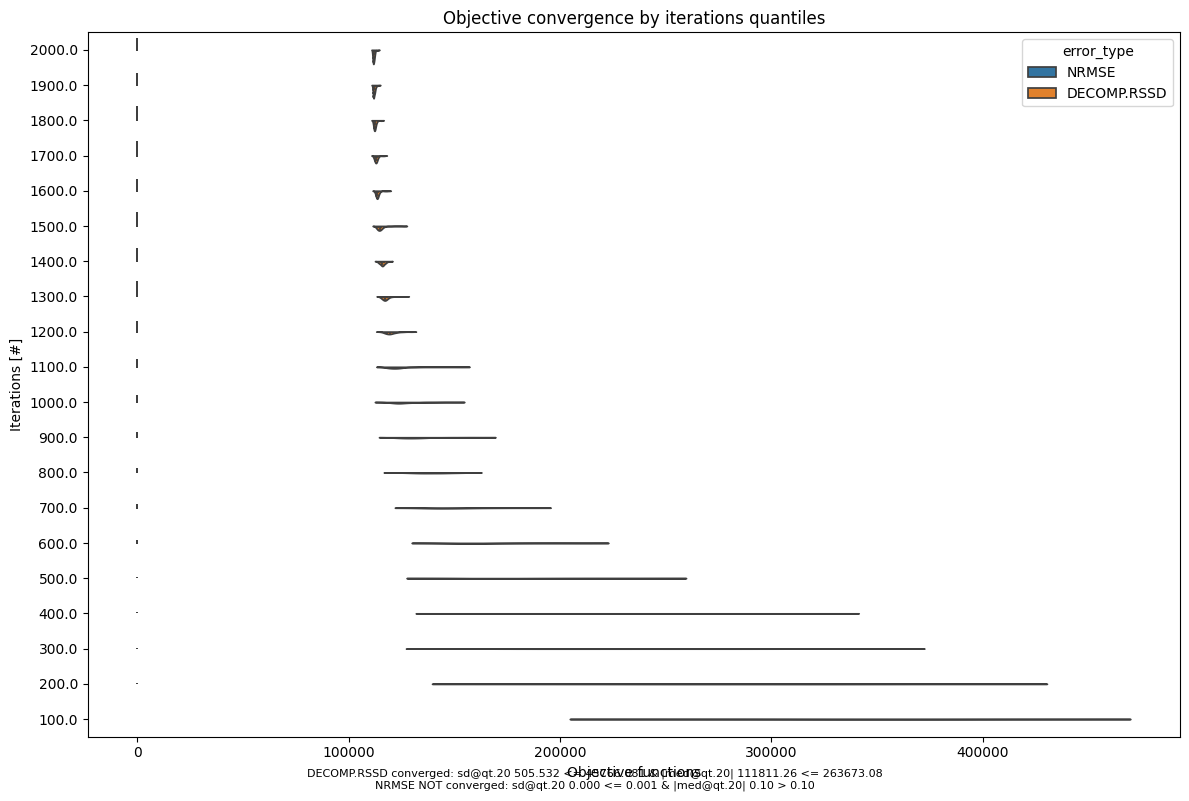

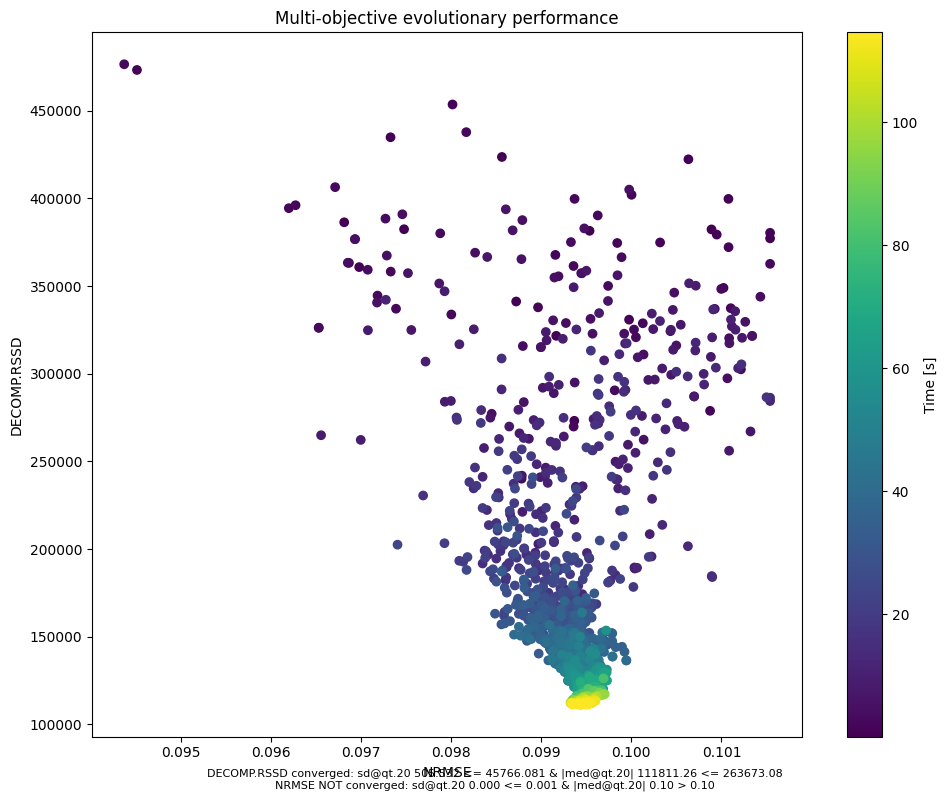

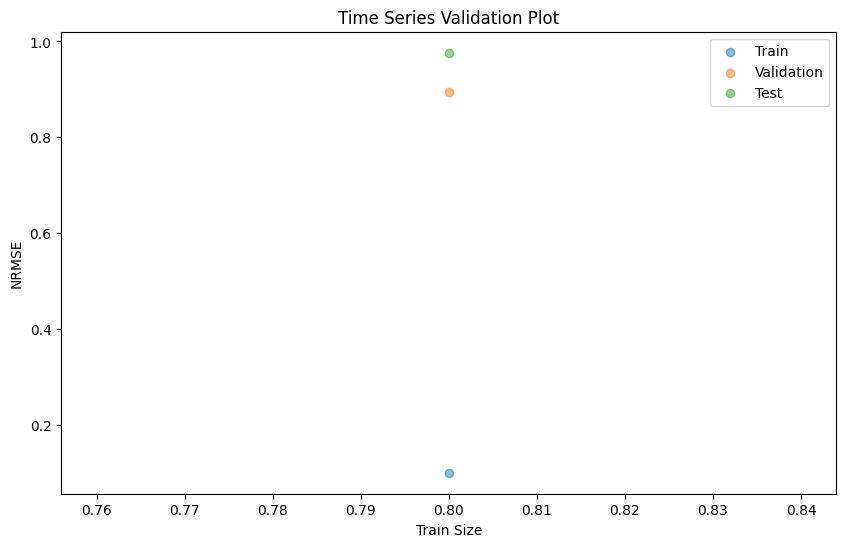

In [9]:
# Setup ModelExecutor
model_executor = ModelExecutor(
    mmmdata=mmm_data,
    holidays_data=holidays_data,
    hyperparameters=hyperparameters,
    calibration_input=None,  # Add calibration input if available
    featurized_mmm_data=featurized_mmm_data,
)

# Setup TrialsConfig
trials_config = TrialsConfig(iterations=2000, trials=5)  # Set to the number of cores you want to use

print(
    f">>> Starting {trials_config.trials} trials with {trials_config.iterations} iterations each using {NevergradAlgorithm.TWO_POINTS_DE.value} nevergrad algorithm on x cores..."
)

# Run the model

output_models = model_executor.model_run(
    trials_config=trials_config,
    ts_validation=True,
    add_penalty_factor=False,
    rssd_zero_penalty=True,
    cores=8,
    nevergrad_algo=NevergradAlgorithm.TWO_POINTS_DE,
    intercept=True,
    intercept_sign="non_negative",
    model_name=Models.RIDGE,
)
print("Model training complete.")

# TODO fix graph outputs

In [ ]:
# Assuming model_outputs.trials[0] is already an object from your model
trial = output_models.trials[0]


# Function to check if an object has a 'shape' attribute
def has_shape(obj):
    return hasattr(obj, "shape")


# Get all attribute names of the object and print their shapes if they have a 'shape' attribute
attribute_names = [attr for attr in dir(trial) if not callable(getattr(trial, attr)) and not attr.startswith("__")]
for attribute_name in attribute_names:
    attribute_value = getattr(trial, attribute_name)
    if has_shape(attribute_value):
        print(f"{attribute_name}: Shape = {attribute_value.shape}")
    else:
        print(f"{attribute_name}: No shape attribute, Type = {type(attribute_value).__name__}")

In [11]:
# Assuming model_outputs.trials[0] is already an object from your model
trial = output_models.trials[0]


# Function to check if an object has a 'shape' attribute
def has_shape(obj):
    return hasattr(obj, "shape")


# Get all attribute names of the object and print their shapes if they have a 'shape' attribute
attribute_names = [attr for attr in dir(trial) if not callable(getattr(trial, attr)) and not attr.startswith("__")]
for attribute_name in attribute_names:
    attribute_value = getattr(trial, attribute_name)
    if has_shape(attribute_value):
        print(f"{attribute_name}: Shape = {attribute_value.shape}")
        # Check if the attribute is a multi-dimensional array with more than one column
        if len(attribute_value.shape) > 1 and attribute_value.shape[1] > 1:
            try:
                # Attempt to print column names if it's a structured array or DataFrame
                columns = (
                    attribute_value.columns if hasattr(attribute_value, "columns") else attribute_value.dtype.names
                )
                print(f"  Columns: {columns}")
            except AttributeError:
                print("  No column names available.")
    else:
        print(f"{attribute_name}: No shape attribute, Type = {type(attribute_value).__name__}")

decomp_rssd: Shape = ()
decomp_spend_dist: Shape = (10000, 34)
  Columns: Index(['rn', 'coef', 'xDecompAgg', 'xDecompPerc', 'xDecompMeanNon0',
       'xDecompMeanNon0Perc', 'xDecompAggRF', 'xDecompPercRF',
       'xDecompMeanNon0RF', 'xDecompMeanNon0PercRF', 'pos', 'mean_spend',
       'total_spend', 'spend_share', 'spend_share_refresh', 'effect_share',
       'effect_share_refresh', 'rsq_train', 'rsq_val', 'rsq_test',
       'nrmse_train', 'nrmse_val', 'nrmse_test', 'nrmse', 'decomp.rssd',
       'mape', 'lambda', 'lambda_hp', 'lambda_max', 'lambda_min_ratio',
       'solID', 'trial', 'iterNG', 'iterPar'],
      dtype='object')
elapsed: No shape attribute, Type = float
elapsed_accum: No shape attribute, Type = float
iter_ng: No shape attribute, Type = int
iter_par: No shape attribute, Type = int
lambda_: No shape attribute, Type = float
lambda_hp: No shape attribute, Type = float
lambda_max: Shape = ()
lambda_min_ratio: No shape attribute, Type = float
lift_calibration: No shape attri